# 📦 PHASE 1: Data Fetching and Engineering

In [8]:
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from volsense_pkg.data_fetching.multi_fetch import fetch_multi_ohlcv, build_multi_dataset

In [4]:
# ------------------------------------------------------------
# 1️⃣ Define universe of 105 tickers (diversified market coverage)
# ------------------------------------------------------------

TICKERS = [
    # Index ETFs
    "SPY", "QQQ", "DIA", "IWM", "VXX", "GLD", "SLV", "TLT", "HYG", "EEM",
    # Tech
    "AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "AVGO", "AMD", "INTC", "ORCL",
    "CRM", "TXN", "QCOM", "ADI", "MU",
    # Financials
    "JPM", "BAC", "C", "WFC", "GS", "MS", "V", "MA", "AXP", "SCHW",
    # Healthcare
    "JNJ", "PFE", "MRK", "UNH", "ABBV", "ABT", "LLY", "BMY", "TMO", "CVS",
    # Energy / Materials
    "XOM", "CVX", "COP", "SLB", "HAL", "BP", "SHEL", "BHP", "RIO", "FCX",
    # Consumer Discretionary
    "TSLA", "HD", "MCD", "NKE", "SBUX", "LOW", "TGT", "BKNG", "CMG", "ROST",
    # Industrials
    "CAT", "BA", "HON", "UPS", "FDX", "UNP", "DE", "LMT", "GE", "RTX",
    # Staples / Retail
    "PG", "KO", "PEP", "COST", "WMT", "CL", "MDLZ", "KMB", "GIS", "KR",
    # Utilities / Real Estate
    "NEE", "DUK", "SO", "XEL", "AEP", "PLD", "AMT",
    # Comms / Media
    "DIS", "CMCSA", "NFLX", "T", "VZ", "TWX", "PARA", "WBD",
    # Bonus (volatile)
    "GME", "AMC", "PYPL", "COIN", "ATVI"
]

print(f"✅ Universe of tickers defined: {len(TICKERS)} total")

✅ Universe of tickers defined: 105 total


In [5]:
# ------------------------------------------------------------
# 2️⃣ Fetch historical OHLCV data (2010–2025)
# ------------------------------------------------------------

start_date = "2010-01-01"
end_date = "2025-12-31"

print(f"\n📡 Fetching data for {len(TICKERS)} tickers from {start_date} to {end_date}...\n")

data_dict = fetch_multi_ohlcv(TICKERS, start=start_date, end=end_date)

# ------------------------------------------------------------
# 3️⃣ Build unified dataset with returns and realized volatility
# ------------------------------------------------------------

LOOKBACK = 15  # short-term rolling window for volatility
multi_df = build_multi_dataset(data_dict, lookback=LOOKBACK)

print("\n✅ Combined dataset created!")
print(f"Shape: {multi_df.shape}")
print(multi_df.head())


📡 Fetching data for 105 tickers from 2010-01-01 to 2025-12-31...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


✅ Combined dataset created!
Shape: (400342, 4)
        date    return  realized_vol ticker
0 2010-01-26  0.014133      0.350305   AAPL
1 2010-01-27  0.009420      0.353315   AAPL
2 2010-01-28 -0.041322      0.385451   AAPL
3 2010-01-29 -0.036279      0.407952   AAPL
4 2010-02-01  0.013902      0.412991   AAPL


In [6]:
print(multi_df.columns)

Index(['date', 'return', 'realized_vol', 'ticker'], dtype='object')


In [7]:
# ------------------------------------------------------------
# 4️⃣ Basic Sanity Checks
# ------------------------------------------------------------

# Ensure no missing columns
assert all(c in multi_df.columns for c in ["date", "return", "realized_vol", "ticker"]), \
    "Missing required columns in dataset."

# Drop any NA
multi_df.dropna(subset=["realized_vol"], inplace=True)
multi_df.reset_index(drop=True, inplace=True)

print(f"\n🧮 After cleaning: {len(multi_df):,} rows across {multi_df['ticker'].nunique()} tickers")


🧮 After cleaning: 400,342 rows across 104 tickers


,mean,std,max,count
ticker,,,,
COIN,0.814672,0.312042,2.001921,1113
AMC,0.748119,1.050811,13.143307,2954
VXX,0.645391,0.365084,2.502239,1922
GME,0.619261,0.726918,8.580002,3951
TSLA,0.528952,0.227642,1.702790,3829
AMD,0.509421,0.229540,2.316547,3951
MU,0.449418,0.174371,1.503072,3951
FCX,0.441549,0.222512,1.989913,3951
NFLX,0.430722,0.238426,1.852551,3951


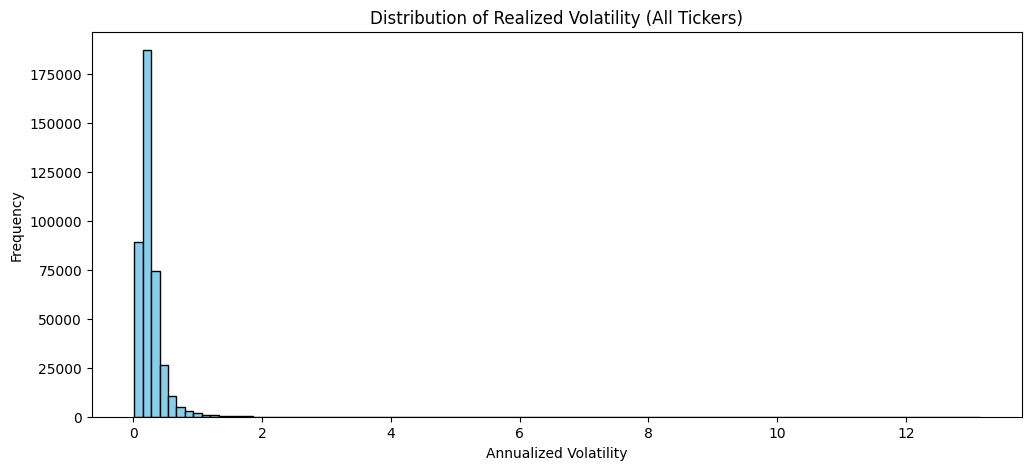

In [8]:
# ------------------------------------------------------------
# 5️⃣ Quick Summary Stats
# ------------------------------------------------------------

agg_stats = multi_df.groupby("ticker")["realized_vol"].agg(["mean", "std", "max", "count"]).sort_values("mean", ascending=False)
display(agg_stats.head(10))

plt.figure(figsize=(12,5))
plt.hist(multi_df["realized_vol"], bins=100, color="skyblue", edgecolor="black")
plt.title("Distribution of Realized Volatility (All Tickers)")
plt.xlabel("Annualized Volatility")
plt.ylabel("Frequency")
plt.show()

In [11]:
# ------------------------------------------------------------
# 6️⃣ Save to CSV for reproducibility
# ------------------------------------------------------------

multi_df.to_csv("../data/processed/global_volatility_dataset.csv", index=False)

print("\n💾 Saved combined dataset to data/global_volatility_dataset.csv")


💾 Saved combined dataset to data/global_volatility_dataset.csv


# PHASE 2: Model Training

In [9]:
# --- Imports
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from volsense_pkg.models.global_vol_forecaster import (
    GlobalVolForecaster, TrainConfig,
    build_global_splits, train_global_model,
    make_last_windows, predict_next_day,
    save_checkpoint
)

## Baseline Model: Stride = 2, layers = 3, hidden layers = 64

In [10]:
# Ensure PyTorch runs efficiently on CPU
torch.set_num_threads(max(1, os.cpu_count() // 2))

# --- Parameters
WINDOW      = 30          # lookback window for LSTM
HORIZONS    = 1           # forecast 1 day ahead
STRIDE      = 2           # sampling stride
VAL_START   = "2025-01-01"  # everything after = validation
DEVICE      = "cpu"

# --- 1. Split the dataset into training and validation sets
train_ds, val_ds, ticker_to_id, scalers = build_global_splits(
    df=multi_df,
    window=WINDOW,
    horizons=HORIZONS,
    stride=STRIDE,
    val_start=VAL_START
)

print(f"✅ Train samples: {len(train_ds):,} | Val samples: {len(val_ds):,}")
print(f"✅ Tickers mapped: {len(ticker_to_id)}")

# --- 2. Define model and training config
cfg = TrainConfig(
    epochs=10,               # start small, tune later
    lr=1e-3,
    batch_size=256,
    oversample_high_vol=True,
    early_stop_patience=3,
    device=DEVICE
)

model = GlobalVolForecaster(
    n_tickers=len(ticker_to_id),
    window=WINDOW,
    n_horizons=(HORIZONS if isinstance(HORIZONS, int) else len(HORIZONS)),
    emb_dim=8,
    hidden_dim=64,
    num_layers=2,
    dropout=0.2,
)

# --- 3. Train the model
history = train_global_model(model, train_ds, val_ds, cfg)

✅ Train samples: 188,773 | Val samples: 9,888
✅ Tickers mapped: 104
Epoch 1/10 | Train Loss: 0.3301 | Val Loss: 0.1781
Epoch 2/10 | Train Loss: 0.1848 | Val Loss: 0.1736
Epoch 3/10 | Train Loss: 0.1780 | Val Loss: 0.1667
Epoch 4/10 | Train Loss: 0.1726 | Val Loss: 0.1612
Epoch 5/10 | Train Loss: 0.1686 | Val Loss: 0.1582
Epoch 6/10 | Train Loss: 0.1648 | Val Loss: 0.1554
Epoch 7/10 | Train Loss: 0.1583 | Val Loss: 0.1442
Epoch 8/10 | Train Loss: 0.1495 | Val Loss: 0.1383
Epoch 9/10 | Train Loss: 0.1447 | Val Loss: 0.1333
Epoch 10/10 | Train Loss: 0.1422 | Val Loss: 0.1332


In [11]:
import math

# Function to unscale back to volatility
def inverse_to_vol(y_scaled: np.ndarray, tkr_ids: np.ndarray) -> np.ndarray:
    out = []
    inv_t2i = {v: k for k, v in ticker_to_id.items()}
    y_scaled = np.atleast_2d(y_scaled)
    for idx, row in enumerate(y_scaled):
        tkr = inv_t2i[int(tkr_ids[idx])]
        sc = scalers[tkr]
        y_log = sc.inverse_transform(row.reshape(-1, 1)).flatten()
        out.append(np.exp(y_log))
    out = np.stack(out)
    return out.squeeze()

# Evaluate on validation set
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)
yhat_scaled_all, ytrue_scaled_all, tid_all = [], [], []

model.eval()
with torch.no_grad():
    for t_id, X, y in val_loader:
        yhat = model(t_id, X)
        yhat_scaled_all.append(yhat.cpu().numpy())
        ytrue_scaled_all.append(y.cpu().numpy())
        tid_all.append(t_id.cpu().numpy())

yhat_scaled = np.concatenate(yhat_scaled_all, axis=0)
ytrue_scaled = np.concatenate(ytrue_scaled_all, axis=0)
tid = np.concatenate(tid_all, axis=0)

# Convert to vol-space
yhat_vol = inverse_to_vol(yhat_scaled, tid)
ytrue_vol = inverse_to_vol(ytrue_scaled, tid)

rmse = math.sqrt(np.mean((yhat_vol - ytrue_vol) ** 2))
mae  = np.mean(np.abs(yhat_vol - ytrue_vol))

print(f"📊 Validation RMSE (vol): {rmse:.6f}, MAE: {mae:.6f}")

📊 Validation RMSE (vol): 0.031752, MAE: 0.015183


In [12]:
# Save model checkpoint
os.makedirs("checkpoints", exist_ok=True)
ckpt_path = "checkpoints/global_vol_lstm_2010_2024_win30_h1_cpu.pth"
save_checkpoint(ckpt_path, model, ticker_to_id, scalers)
print(f"💾 Model saved to: {ckpt_path}")

💾 Model saved to: checkpoints/global_vol_lstm_2010_2024_win30_h1_cpu.pth


In [ ]:
# Predict next-day volatility for each ticker
last_windows = make_last_windows(multi_df, window=WINDOW)
pred_df = predict_next_day(
    model=model,
    df_last_windows=last_windows,
    ticker_to_id=ticker_to_id,
    scalers=scalers,
    window=WINDOW,
    device=DEVICE,
)

print(f"✅ {len(pred_df)} forecasts generated")
display(pred_df.head())

## Model #2 : Stride = 1, layers = 3, hidden layers = 128, Epochs = 15

In [17]:
# --- Parameters
WINDOW      = 40          # lookback window for LSTM
HORIZONS    = 1           # forecast 1 day ahead
STRIDE      = 1           # sampling stride
VAL_START   = "2025-01-01"  # everything after = validation
DEVICE      = "cpu"

# --- 1. Split the dataset into training and validation sets
train_ds, val_ds, ticker_to_id, scalers = build_global_splits(
    df=multi_df,
    window=WINDOW,
    horizons=HORIZONS,
    stride=STRIDE,
    val_start=VAL_START
)

print(f"✅ Train samples: {len(train_ds):,} | Val samples: {len(val_ds):,}")
print(f"✅ Tickers mapped: {len(ticker_to_id)}")

# --- 2. Define model and training config
cfg_2 = TrainConfig(
    epochs=15,               # start small, tune later
    lr=5e-4,
    batch_size=256,
    oversample_high_vol=True,
    early_stop_patience=5,
    device=DEVICE
)

model_2 = GlobalVolForecaster(
    n_tickers=len(ticker_to_id),
    window=WINDOW,
    n_horizons=(HORIZONS if isinstance(HORIZONS, int) else len(HORIZONS)),
    emb_dim=12,
    hidden_dim=128,
    num_layers=3,
    dropout=0.1,
)

# --- 3. Train the model
history_2 = train_global_model(model_2, train_ds, val_ds, cfg_2)

✅ Train samples: 376,406 | Val samples: 19,776
✅ Tickers mapped: 104
Epoch 1/15 | Train Loss: 0.2371 | Val Loss: 0.1735
Epoch 2/15 | Train Loss: 0.1532 | Val Loss: 0.1624
Epoch 3/15 | Train Loss: 0.1455 | Val Loss: 0.1501
Epoch 4/15 | Train Loss: 0.1372 | Val Loss: 0.1536
Epoch 5/15 | Train Loss: 0.1329 | Val Loss: 0.1390
Epoch 6/15 | Train Loss: 0.1317 | Val Loss: 0.1420
Epoch 7/15 | Train Loss: 0.1277 | Val Loss: 0.1385
Epoch 8/15 | Train Loss: 0.1262 | Val Loss: 0.1369
Epoch 9/15 | Train Loss: 0.1259 | Val Loss: 0.1369
Epoch 10/15 | Train Loss: 0.1267 | Val Loss: 0.1393
Epoch 11/15 | Train Loss: 0.1242 | Val Loss: 0.1408
Epoch 12/15 | Train Loss: 0.1211 | Val Loss: 0.1319
Epoch 13/15 | Train Loss: 0.1214 | Val Loss: 0.1384
Epoch 14/15 | Train Loss: 0.1205 | Val Loss: 0.1298
Epoch 15/15 | Train Loss: 0.1205 | Val Loss: 0.1308


In [18]:
# Evaluate on validation set
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)
yhat_scaled_all, ytrue_scaled_all, tid_all = [], [], []

model_2.eval()
with torch.no_grad():
    for t_id, X, y in val_loader:
        yhat = model_2(t_id, X)
        yhat_scaled_all.append(yhat.cpu().numpy())
        ytrue_scaled_all.append(y.cpu().numpy())
        tid_all.append(t_id.cpu().numpy())

yhat_scaled = np.concatenate(yhat_scaled_all, axis=0)
ytrue_scaled = np.concatenate(ytrue_scaled_all, axis=0)
tid = np.concatenate(tid_all, axis=0)

# Convert to vol-space
yhat_vol = inverse_to_vol(yhat_scaled, tid)
ytrue_vol = inverse_to_vol(ytrue_scaled, tid)

rmse = math.sqrt(np.mean((yhat_vol - ytrue_vol) ** 2))
mae  = np.mean(np.abs(yhat_vol - ytrue_vol))

print(f"📊 Validation RMSE (vol): {rmse:.6f}, MAE: {mae:.6f}")

📊 Validation RMSE (vol): 0.031721, MAE: 0.015012


In [23]:
multi_df

,date,return,realized_vol,ticker,realized_vol_log,day_of_week,month_sin,month_cos
0,2010-01-26,0.014133,0.350304,AAPL,-1.048952,0.166667,0.500000,0.866025
1,2010-01-27,0.009420,0.353314,AAPL,-1.040396,0.333333,0.500000,0.866025
2,2010-01-28,-0.041322,0.385450,AAPL,-0.953341,0.500000,0.500000,0.866025
3,2010-01-29,-0.036279,0.407951,AAPL,-0.896606,0.666667,0.500000,0.866025
4,2010-02-01,0.013902,0.412990,AAPL,-0.884329,0.000000,0.866025,0.500000
...,...,...,...,...,...,...,...,...
400336,2025-10-02,-0.006251,0.201388,XOM,-1.602516,0.500000,-0.866025,0.500000
400337,2025-10-03,0.017702,0.214711,XOM,-1.538458,0.666667,-0.866025,0.500000
400338,2025-10-06,0.008299,0.216937,XOM,-1.528145,0.000000,-0.866025,0.500000
400339,2025-10-07,0.000525,0.199225,XOM,-1.613314,0.166667,-0.866025,0.500000


In [20]:
# Save model checkpoint
os.makedirs("checkpoints", exist_ok=True)
ckpt_path = "checkpoints/global_vol_lstm_2010_2024_win30_h1_cpu_tuned_3.pth"
save_checkpoint(ckpt_path, model_2, ticker_to_id, scalers)
print(f"💾 Model saved to: {ckpt_path}")

💾 Model saved to: checkpoints/global_vol_lstm_2010_2024_win30_h1_cpu_tuned_3.pth


# Run 4

In [ ]:
# Ensure we're importing the local, updated module (not an older installed copy)
import sys, os, importlib
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import volsense_pkg.models.global_vol_forecaster as gvf
importlib.reload(gvf)
print("Using global_vol_forecaster from:", gvf.__file__)

from volsense_pkg.models.global_vol_forecaster import TrainConfig, train_global_model


In [3]:
from volsense_pkg.models.global_vol_forecaster import TrainConfig, train_global_model

multi_df = pd.read_csv("../data/processed/global_volatility_dataset.csv")

EPS = 1e-6

multi_df = multi_df.copy() 
multi_df["date"] = pd.to_datetime(multi_df["date"], errors="coerce") 
multi_df.dropna(subset=["date"], inplace=True) # Log-vol target 
multi_df["realized_vol_log"] = np.log(multi_df["realized_vol"] + EPS) # Cyclical & weekday features 
multi_df["day_of_week"] = multi_df["date"].dt.dayofweek / 6.0 
multi_df["month_sin"] = np.sin(2 * np.pi * multi_df["date"].dt.month / 12) 
multi_df["month_cos"] = np.cos(2 * np.pi * multi_df["date"].dt.month / 12)

cfg = TrainConfig(
    epochs=20,
    lr=3e-4,
    batch_size=256,
    device="cpu",
    val_start="2025-01-01",
    window=40,
    horizons=1,
    extra_features=["day_of_week", "month_sin", "month_cos"],
    target_col="realized_vol_log"
)

model, hist, val_loader, ticker_to_id, scalers, features = train_global_model(multi_df, cfg)


🚀 Training GlobalVolForecaster on 104 tickers...

Epoch 1/20 | Train Loss: 0.1904 | Val Loss: 0.0730
Epoch 1/20 | Train Loss: 0.1904 | Val Loss: 0.0730
Epoch 2/20 | Train Loss: 0.0593 | Val Loss: 0.0646
Epoch 2/20 | Train Loss: 0.0593 | Val Loss: 0.0646
Epoch 3/20 | Train Loss: 0.0518 | Val Loss: 0.0592
Epoch 3/20 | Train Loss: 0.0518 | Val Loss: 0.0592
Epoch 4/20 | Train Loss: 0.0475 | Val Loss: 0.0632
Epoch 4/20 | Train Loss: 0.0475 | Val Loss: 0.0632
Epoch 5/20 | Train Loss: 0.0447 | Val Loss: 0.0564
Epoch 5/20 | Train Loss: 0.0447 | Val Loss: 0.0564
Epoch 6/20 | Train Loss: 0.0425 | Val Loss: 0.0519
Epoch 6/20 | Train Loss: 0.0425 | Val Loss: 0.0519
Epoch 7/20 | Train Loss: 0.0412 | Val Loss: 0.0527
Epoch 7/20 | Train Loss: 0.0412 | Val Loss: 0.0527
Epoch 8/20 | Train Loss: 0.0403 | Val Loss: 0.0520
Epoch 8/20 | Train Loss: 0.0403 | Val Loss: 0.0520
Epoch 9/20 | Train Loss: 0.0395 | Val Loss: 0.0500
Epoch 9/20 | Train Loss: 0.0395 | Val Loss: 0.0500
Epoch 10/20 | Train Loss: 0.038

In [ ]:
import os
import torch

# Save trained model weights to checkpoints folder
os.makedirs("checkpoints", exist_ok=True)
ckpt_path = f"checkpoints/global_vol_forecaster_win{cfg.window}_h{cfg.horizons}_{cfg.device}.pth"
torch.save(model.state_dict(), ckpt_path)
print(f"\U0001F4BE Saved model weights to: {ckpt_path}")


📊 Validation RMSE (vol): 0.040630 | MAE: 0.016839


,ticker,rmse,mae,n
44,HYG,0.006252,0.002780,151
88,TLT,0.007496,0.004995,151
37,GLD,0.010855,0.007263,151
31,DUK,0.010981,0.006847,151
84,SO,0.011376,0.007223,151
4,AEP,0.011959,0.007698,151
50,KO,0.012396,0.006937,151
71,PG,0.014183,0.008563,151
19,CL,0.014517,0.009120,151
7,AMT,0.015059,0.010008,151


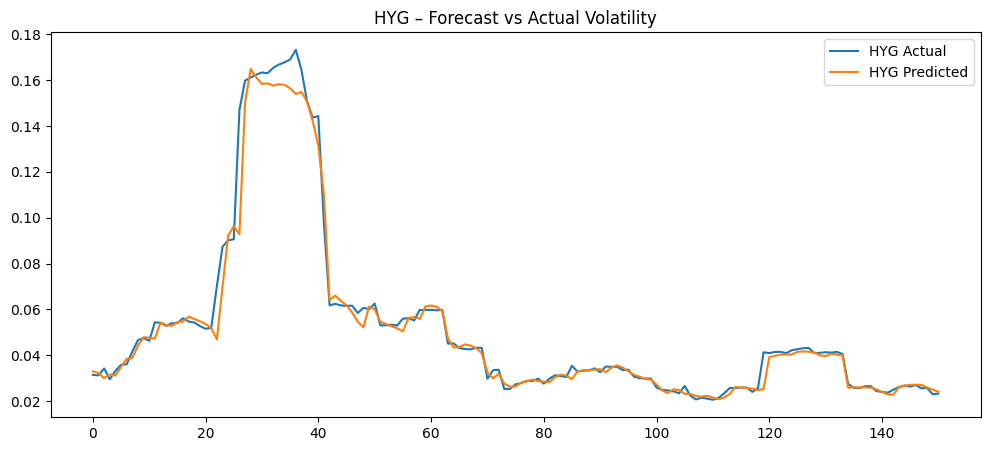

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

DEVICE = cfg.device
MODEL = model.to(DEVICE)
MODEL.eval()

# --- Run inference ---
all_preds, all_trues, all_tids = [], [], []

with torch.no_grad():
    for tid, X, y in val_loader:
        tid, X, y = tid.to(DEVICE), X.to(DEVICE), y.to(DEVICE)
        preds = MODEL(tid, X)
        all_preds.append(preds.cpu().numpy())
        all_trues.append(y.cpu().numpy())
        all_tids.append(tid.cpu().numpy())

preds_scaled = np.concatenate(all_preds)
trues_scaled = np.concatenate(all_trues)
tids = np.concatenate(all_tids)

# --- Invert scaling and exp back to vol ---
id_to_ticker = {v: k for k, v in ticker_to_id.items()}
preds_vol, trues_vol = np.empty_like(preds_scaled), np.empty_like(trues_scaled)

for tid in np.unique(tids):
    mask = (tids == tid)
    tkr = id_to_ticker[int(tid)]
    sc_y = scalers[tkr]["y"]
    p_log = sc_y.inverse_transform(preds_scaled[mask].reshape(-1, 1)).ravel()
    y_log = sc_y.inverse_transform(trues_scaled[mask].reshape(-1, 1)).ravel()
    preds_vol[mask] = np.exp(p_log)
    trues_vol[mask] = np.exp(y_log)

# --- Compute aggregate metrics ---
rmse = np.sqrt(mean_squared_error(trues_vol, preds_vol))
mae = mean_absolute_error(trues_vol, preds_vol)
print(f"📊 Validation RMSE (vol): {rmse:.6f} | MAE: {mae:.6f}")

# --- Per-ticker metrics ---
rows = []
for tid in np.unique(tids):
    tkr = id_to_ticker[int(tid)]
    m = (tids == tid)
    rows.append({
        "ticker": tkr,
        "rmse": np.sqrt(mean_squared_error(trues_vol[m], preds_vol[m])),
        "mae": mean_absolute_error(trues_vol[m], preds_vol[m]),
        "n": int(m.sum())
    })
metrics_df = pd.DataFrame(rows).sort_values("rmse")
display(metrics_df.head(15))

# --- Plot a few representative tickers ---
plt.figure(figsize=(12,5))
top_ticker = metrics_df.iloc[0]["ticker"]
mask = (tids == list(id_to_ticker.keys())[list(id_to_ticker.values()).index(top_ticker)])
plt.plot(trues_vol[mask][:200], label=f"{top_ticker} Actual")
plt.plot(preds_vol[mask][:200], label=f"{top_ticker} Predicted")
plt.title(f"{top_ticker} – Forecast vs Actual Volatility")
plt.legend()
plt.show()


In [10]:
import os
import torch

# Save the entire model object (architecture + weights)
os.makedirs("checkpoints", exist_ok=True)
full_model_path = f"checkpoints/global_vol_forecaster_win{cfg.window}_h{cfg.horizons}_{cfg.device}_full.pth"
torch.save(model, full_model_path)
print(f"💾 Saved full model object to: {full_model_path}")

💾 Saved full model object to: checkpoints/global_vol_forecaster_win40_h1_cpu_full.pth


In [ ]:

import pickle
# Save as pickle files
os.makedirs("checkpoints", exist_ok=True)

# 1) Full model object (.pkl) — simple to load but depends on module path staying the same
full_pkl_path = f"checkpoints/global_vol_forecaster_win{cfg.window}_h{cfg.horizons}_{cfg.device}_full.pkl"
with open(full_pkl_path, "wb") as f:
    pickle.dump(model, f)
print(f"💾 Saved full model (pickle) to: {full_pkl_path}")

# 2) Portable bundle (.pkl) — recommended for robustness
bundle = {
    "arch": model.__class__.__name__,
    "module_path": model.__class__.__module__,  # for reference
    "state_dict": model.state_dict(),
    "cfg": cfg,
    "features": features,
    "ticker_to_id": ticker_to_id,
    "scalers": scalers,
}
bundle_pkl_path = f"checkpoints/global_vol_forecaster_win{cfg.window}_h{cfg.horizons}_{cfg.device}_bundle.pkl"
with open(bundle_pkl_path, "wb") as f:
    pickle.dump(bundle, f)
print(f"💾 Saved portable bundle (pickle) to: {bundle_pkl_path}")

In [9]:
out_path = "../data/metrics/global_lstm_metrics.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
metrics_df.to_csv(out_path, index=False)
print(f"Saved metrics to: {out_path}")

Saved metrics to: ../data/metrics/global_lstm_metrics.csv
